In [32]:
import cdlib
import pandas as pd
import networkx as nx
from cdlib import algorithms
from collections import Counter
import plotly.express as px
from cdlib import evaluation
from cdlib import viz
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools

# Graph Generation

In [53]:
node_list = pd.read_csv('data/bd-node.csv', index_col = 'id')
edge_list = pd.read_csv('data/bd-edge.csv')

In [54]:
node_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11775 entries, 0 to 20498
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   titolo                    11775 non-null  object 
 1   autore                    11775 non-null  object 
 2   editore                   11775 non-null  object 
 3   categoria                 11775 non-null  object 
 4   raccomandazioni-ricevute  11775 non-null  float64
 5   anno-pubblicazione        11775 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 643.9+ KB


In [55]:
node_list.head()

,titolo,autore,editore,categoria,raccomandazioni-ricevute,anno-pubblicazione
id,,,,,,
0,Cambiare l'acqua ai fiori,Perrin Valérie,E/O,Letterature straniere: testi,64.0,2019
1,"Ragazza, donna, altro",Evaristo Bernardine,Sur,Letterature straniere: testi,61.0,2020
2,L'Ickabog,Rowling J. K.,Salani,Letteratura per ragazzi,44.0,2020
3,Dante,Barbero Alessandro,Laterza,Letteratura italiana: critica,37.0,2020
4,Borgo Sud,Di Pietrantonio Donatella,Einaudi,Letteratura italiana: testi,36.0,2020


In [36]:
g = nx.from_pandas_edgelist(edge_list, 'Source', 'Target', ['Weight'])

In [37]:
# Create a nested dict with info for each node of the nodelist
info_nodes = {}

for index, row in node_list.iterrows():
    info_nodes[index] = {'book_name': row['titolo'], 
                         'book_author': row['autore'], 
                         'book_publisher': row['editore'],
                         'book_genre': row['categoria'], 
                         'recommendations_received' : row['raccomandazioni-ricevute'], 
                         'year_of_publication': row['anno-pubblicazione']}

In [38]:
info_nodes[11818]

{'book_name': 'Hokusai. Pop-up',
 'book_author': 'McCarthy Courtney Watson',
 'book_publisher': 'White Star',
 'book_genre': 'Disegno, arti decorative e minori',
 'recommendations_received': 1.0,
 'year_of_publication': 2016}

In [39]:
len(info_nodes)

11775

In [40]:
len(nx.nodes(g))

11775

In [41]:
# Setting the attributes of each node using the info contained in the nested dict
nx.set_node_attributes(g, info_nodes)

In [42]:
# Get node attributes:

name = nx.get_node_attributes(g, "book_name")
author = nx.get_node_attributes(g, "book_author")
publisher = nx.get_node_attributes(g, "book_publisher")
genre = nx.get_node_attributes(g, "book_genre")
recommendations = nx.get_node_attributes(g, "recommendations_received")
year = nx.get_node_attributes(g, "year_of_publication")

In [43]:
genre[11818]

'Disegno, arti decorative e minori'

In [44]:
name[11818]

'Hokusai. Pop-up'

In [56]:
nx.attribute_assortativity_coefficient(g, attribute='book_genre')

0.21749953855988688

In [57]:
nx.attribute_assortativity_coefficient(g, attribute='book_publisher')

0.04763819554350018

In [14]:
# Use the giant component
comps = list(nx.connected_components(g))
GC = g.subgraph(comps[0])
g = GC

In [15]:
len(g)

11573

# Community Discovery algorithms

## Approach 1: Internal Density
Communities as sets of densely connected entities
Each community must have a number of edges significantly higher than what expected in a random graph

### Louvain

It works finding a function of density and maxime it.


In [16]:
louv_coms = algorithms.louvain(g, weight='weight', resolution=1.)

In [17]:
louv_coms.method_name

'Louvain'

In [18]:
# Function to retrieve the info of the communities found out by the algorithm
def info_community(communities, algorithm):    
    C = [g.subgraph(c).copy() for c in communities]
    # Build a list with all info
    info = dict()    
    for count, comm in enumerate(C):        
        info[count] = {'nodes': nx.number_of_nodes(comm), 
                       'edges': nx.number_of_edges(comm)}
    return info

In [19]:
info_louv = info_community(louv_coms.communities, louv_coms)
info_louv

{0: {'nodes': 1824, 'edges': 157646},
 1: {'nodes': 1660, 'edges': 83919},
 2: {'nodes': 1627, 'edges': 91696},
 3: {'nodes': 858, 'edges': 38027},
 4: {'nodes': 825, 'edges': 88861},
 5: {'nodes': 741, 'edges': 52653},
 6: {'nodes': 468, 'edges': 25660},
 7: {'nodes': 435, 'edges': 26539},
 8: {'nodes': 381, 'edges': 11653},
 9: {'nodes': 348, 'edges': 25442},
 10: {'nodes': 323, 'edges': 41032},
 11: {'nodes': 295, 'edges': 12777},
 12: {'nodes': 288, 'edges': 10816},
 13: {'nodes': 257, 'edges': 7163},
 14: {'nodes': 249, 'edges': 10201},
 15: {'nodes': 246, 'edges': 8740},
 16: {'nodes': 222, 'edges': 6040},
 17: {'nodes': 156, 'edges': 10914},
 18: {'nodes': 126, 'edges': 4347},
 19: {'nodes': 116, 'edges': 3839},
 20: {'nodes': 34, 'edges': 561},
 21: {'nodes': 28, 'edges': 378},
 22: {'nodes': 17, 'edges': 136},
 23: {'nodes': 17, 'edges': 136},
 24: {'nodes': 11, 'edges': 55},
 25: {'nodes': 11, 'edges': 55},
 26: {'nodes': 10, 'edges': 45}}

In [20]:
print(f"Nodes: {evaluation.size(g, louv_coms)}")
print(f"Edges: {evaluation.edges_inside(g, louv_coms)}")
if louv_coms.overlap: 
    print('Overlapping')
else: print('No overlapping')

Nodes: FitnessResult(min=10, max=1824, score=428.6296296296296, std=508.3828499123943)
Edges: FitnessResult(min=45, max=157646, score=26641.88888888889, std=37408.82409601929)
No overlapping


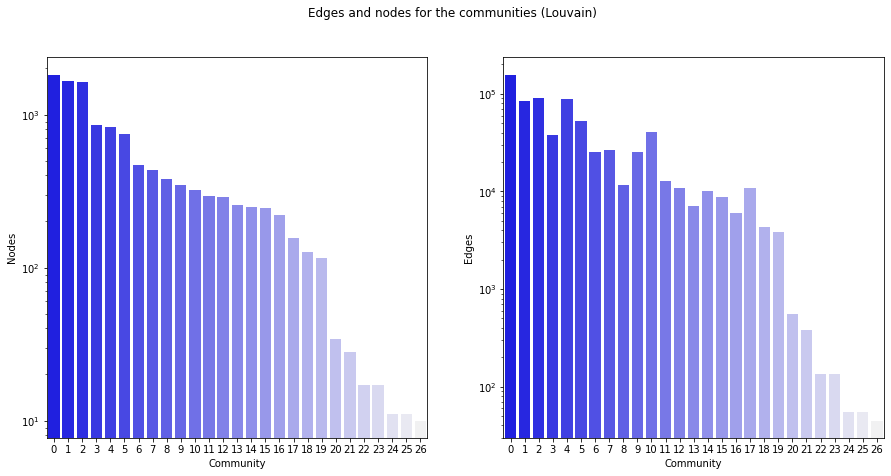

In [21]:
fig, axes = plt.subplots(1,2, figsize=(15, 7))

sns.barplot(ax=axes[0], 
            x=list(info_louv.keys()), 
            y=[c['nodes'] for c in info_louv.values()],
            palette='light:b_r')

axes[0].set_xlabel('Community')
axes[0].set_ylabel('Nodes')
axes[0].set_yscale('log')

sns.barplot(ax=axes[1],
            x=list(info_louv.keys()),
            y=[c['edges'] for c in info_louv.values()],
            palette='light:b_r')

axes[1].set_xlabel('Community')
axes[1].set_ylabel('Edges')
axes[1].set_yscale('log')

plt.suptitle("Edges and nodes for the communities (Louvain)")
plt.show()

#### Internal Evaluation: Fitness scores

##### Partitions quality functions
Using some fitness functions that can be defined to assess the quality of a partition

In [22]:
def fitness_functions(community_type):

    print("INTERNAL EVALUATION")
    print()
    #average internal degree (AID) = the average internal degree of the community set.
    print(f"1 - Average Internal Degree: \n{evaluation.average_internal_degree(g, community_type)}")
    print()
    print()
    #internal edge density (IED) = The internal density of the community set.
    print(f"2 - Internal Edge Density: \n{evaluation.internal_edge_density(g,community_type)}")
    print()
    print()
    #conductance (C) = Fraction of total edge volume that points outside the community.
    print(f"3 - Conductance : \n{evaluation.conductance(g,community_type)}")
    print()
    print()
    # Triangle participation ratio (TPR) = Fraction of community nodes that belong to a triad.
    print(f"4 - Triangle Participation Ratio : \n{evaluation.triangle_participation_ratio(g,community_type)}")
    print()
    print()
    # #Girvan-Newmann modularity (GNM)
    print(f"5 - Newmann modularity : \n{evaluation.newman_girvan_modularity(g,community_type)}")
    print()
    print()
    #Expansion = Number of edges per community node that point outside the cluster.
    print(f"6 - Expansion : \n{evaluation.expansion(g,community_type)}")
    print()
    print()
    #Normalized-cut (NC)= normalized variant of cut-ratio, that is the fraction of existing edges (out of all possible edges) leaving the community.
    print(f"7 - Normalized cut : \n{evaluation.normalized_cut(g,community_type)}")
    print()
    print()
    #Average ODF Degree (AODFD): the average fraction of edges of a node of a community that point outside the community itself.
    print(f"8 - Average ODF Degree : \n{evaluation.avg_odf(g,community_type)}")
    print()
    print()
    #Flake ODF = Fraction of nodes in S that have fewer edges pointing inside than to the outside of the community.
    print(f"9 - Flake ODF : \n{evaluation.flake_odf(g,community_type)}")
    print()
    print()
    # Fraction over median degree = Fraction of community nodes of having internal degree higher than the median degree value.
    print(f"10 - Fraction over median degree : \n{evaluation.fraction_over_median_degree(g,community_type)}")
    print()
    print()
    # Node_coverage = Fraction of total edge volume that points outside the community.
    print(f"11 - Node coverage : \n{community_type.node_coverage}")




In [23]:
fitness_functions(louv_coms)

INTERNAL EVALUATION

1 - Average Internal Degree: 
FitnessResult(min=9.0, max=254.06811145510835, score=86.92551888128546, std=61.50798160425015)


2 - Internal Edge Density: 
FitnessResult(min=0.06094468289069479, max=1.0, score=0.4940876341096815, std=0.3553747517511876)


3 - Conductance : 
FitnessResult(min=0.09090909090909091, max=0.37932328986240554, score=0.22547567044275604, std=0.08798997909752239)


4 - Triangle Participation Ratio : 
FitnessResult(min=0.9942528735632183, max=1.0, score=0.999073755362944, std=0.0015763162500455003)


5 - Newmann modularity : 
FitnessResult(min=None, max=None, score=0.6192250770937667, std=None)


6 - Expansion : 
FitnessResult(min=1.0, max=98.98060606060606, score=29.793423342593975, std=22.885349672423242)


7 - Normalized cut : 
FitnessResult(min=0.09091465944947016, max=0.4032093111953771, score=0.2360696220731269, std=0.09558396420683443)


8 - Average ODF Degree : 
FitnessResult(min=1.0, max=98.98060606060606, score=29.793423342593975, s

#### External Evaluation: Purity 

In clustering, purity is used to measure the extent to which cluster labels match externally supplied class labels (also entropy can be used).

In [24]:
test_community = louv_coms.communities[0]

In [25]:
test_genres = [genre[idx] for idx in test_community]

In [26]:
# Compute frequency distribution for genre
test_genre_distr = sorted(
    [(genre, test_genres.count(genre)) for genre in list(set(test_genres))],
    key=lambda t: t[1],
    reverse=True)

In [27]:
test_genre_distr[:10]

[('Letterature straniere: testi', 882),
 ('Letteratura italiana: testi', 398),
 ('Scienze sociali', 88),
 ('Letteratura per ragazzi', 77),
 ('Disegno, arti decorative e minori', 68),
 ('Scienza politica', 38),
 ('Problemi e servizi sociali', 37),
 ('Arti ricreative. spettacolo. sport', 36),
 ('Geografia generale. viaggi', 24),
 ('Musica', 20)]

In [28]:
def compute_purity(freqs):    
    purity = max(freqs)/sum(f for f in freqs)
    return purity

In [29]:
compute_purity([t[1] for t in test_genre_distr])

0.48355263157894735

In [30]:
def compute_overall_purity(communities, node_attributes, weighted=True):
    total_nodes = sum(len(community) for community in communities)
    weighted_purities = list()
    purities = list()
    for community in communities:        
        attributes_in_community = [node_attributes[idx] for idx in community] 
        freqs_in_community = [attributes_in_community.count(attribute) 
                              for attribute in list(set(attributes_in_community))]
        nodes_in_community = (sum(freqs_in_community))                
        purity = compute_purity(freqs_in_community)                
        weighted_purity = purity*(nodes_in_community/total_nodes)        
        weighted_purities.append(weighted_purity)
        purities.append(purity)        
    if weighted:
        return sum(weighted_purities)
    else:
        return sum(purities)/len(purities)

In [31]:
w_genre_purity = compute_overall_purity(louv_coms.communities, genre)
genre_purity = compute_overall_purity(louv_coms.communities, genre, weighted=False)

In [32]:
w_publisher_purity = compute_overall_purity(louv_coms.communities, publisher)
publisher_purity = compute_overall_purity(louv_coms.communities, publisher, weighted=False)

In [33]:
# Compute purity for entire network
network_genre_purity = compute_purity([list(genre.values()).count(g) 
                                       for g in list(set(list(genre.values())))])
network_publisher_purity = compute_purity([list(publisher.values()).count(g) 
                                           for g in list(set(list(publisher.values())))])

In [34]:
print(f'GENRE')
print(f'Purity: {genre_purity}, Weighted: {w_genre_purity}')
print(f'Overall Network: {network_genre_purity}')

GENRE
Purity: 0.4283752055045245, Weighted: 0.4599498833491747
Overall Network: 0.2714225053078556


In [35]:
print(f'PUBLISHER')
print(f'Purity: {publisher_purity}, Weighted: {w_publisher_purity}')
print(f'Overall Network: {network_publisher_purity}')

PUBLISHER
Purity: 0.1541136053243841, Weighted: 0.0958264926985224
Overall Network: 0.04704883227176221



## Approach 2: Percolation
Communities as a set of nodes grouped together by the propagation of a same property/action/information

### Label Propagation

In [36]:
lp_coms = algorithms.label_propagation(g)

In [37]:
lp_coms.method_name

'Label Propagation'

In [38]:
info_lp = info_community(lp_coms.communities, lp_coms)
info_lp

{0: {'nodes': 9353, 'edges': 910191},
 1: {'nodes': 150, 'edges': 6757},
 2: {'nodes': 121, 'edges': 3949},
 3: {'nodes': 99, 'edges': 4851},
 4: {'nodes': 89, 'edges': 3916},
 5: {'nodes': 80, 'edges': 3160},
 6: {'nodes': 79, 'edges': 3081},
 7: {'nodes': 73, 'edges': 1336},
 8: {'nodes': 72, 'edges': 1404},
 9: {'nodes': 71, 'edges': 2485},
 10: {'nodes': 62, 'edges': 967},
 11: {'nodes': 58, 'edges': 1653},
 12: {'nodes': 51, 'edges': 1275},
 13: {'nodes': 47, 'edges': 993},
 14: {'nodes': 44, 'edges': 864},
 15: {'nodes': 43, 'edges': 903},
 16: {'nodes': 36, 'edges': 506},
 17: {'nodes': 36, 'edges': 630},
 18: {'nodes': 35, 'edges': 307},
 19: {'nodes': 33, 'edges': 528},
 20: {'nodes': 29, 'edges': 238},
 21: {'nodes': 29, 'edges': 406},
 22: {'nodes': 24, 'edges': 186},
 23: {'nodes': 22, 'edges': 231},
 24: {'nodes': 22, 'edges': 231},
 25: {'nodes': 21, 'edges': 210},
 26: {'nodes': 20, 'edges': 102},
 27: {'nodes': 20, 'edges': 190},
 28: {'nodes': 20, 'edges': 190},
 29: {

In [39]:
print(f"Nodes: {evaluation.size(g, lp_coms)}")
print(f"Edges: {evaluation.edges_inside(g, lp_coms)}")
if lp_coms.overlap: 
    print('Overlapping')
else: print('No overlapping')

Nodes: FitnessResult(min=2, max=9353, score=107.1574074074074, std=894.1987222382605)
Edges: FitnessResult(min=1, max=910191, score=8849.398148148148, std=87142.35172277981)
No overlapping


In [40]:
lp_coms.size()

FitnessResult(min=2, max=9353, score=107.1574074074074, std=894.1987222382605)

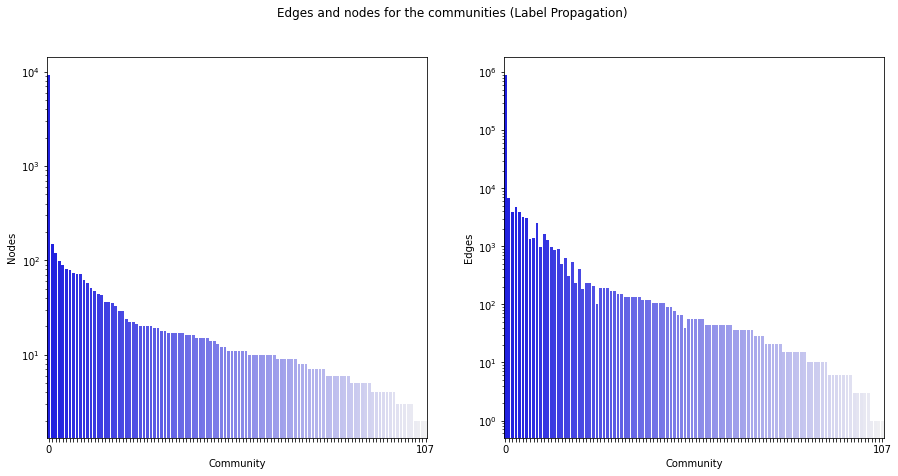

In [41]:
fig, axes = plt.subplots(1,2, figsize=(15, 7))

sns.barplot(ax=axes[0], 
            x=list(info_lp.keys()), 
            y=[c['nodes'] for c in info_lp.values()],
            palette='light:b_r')

axes[0].set_xlabel('Community')
axes[0].set_ylabel('Nodes')
axes[0].set_yscale('log')

# Show only min and max of x tick labels
min_max = [min(list(info_lp.keys())), max(list(info_lp.keys()))]
for index, label in enumerate(axes[0].get_xticklabels()):
   if index in min_max:
      label.set_visible(True)
   else:
      label.set_visible(False)


sns.barplot(ax=axes[1],
            x=list(info_lp.keys()),
            y=[c['edges'] for c in info_lp.values()],
            palette='light:b_r')

axes[1].set_xlabel('Community')
axes[1].set_ylabel('Edges')
axes[1].set_yscale('log')

# Show only min and max of x tick labels
for index, label in enumerate(axes[1].get_xticklabels()):
   if index in min_max:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.suptitle("Edges and nodes for the communities (Label Propagation)")
plt.show()

In [42]:
fitness_functions(lp_coms)

INTERNAL EVALUATION

1 - Average Internal Degree: 
FitnessResult(min=1.0, max=194.6308136426815, score=18.8442581410357, std=26.39105196437351)


2 - Internal Edge Density: 
FitnessResult(min=0.020811678105504865, max=1.0, score=0.9481069277673193, std=0.15455223715201294)


3 - Conductance : 
FitnessResult(min=0.016835587835947532, max=0.5714285714285714, score=0.344580279492796, std=0.1319559418923727)


4 - Triangle Participation Ratio : 
FitnessResult(min=0.0, max=1.0, score=0.9629599930305587, std=0.18885199462371216)


5 - Newmann modularity : 
FitnessResult(min=None, max=None, score=0.08889187188396865, std=None)


6 - Expansion : 
FitnessResult(min=1.0, max=47.44444444444444, score=7.9959156306567865, std=8.269557333306938)


7 - Normalized cut : 
FitnessResult(min=0.05211556500816209, max=0.571436670701358, score=0.34628393276137215, std=0.12901344898105024)


8 - Average ODF Degree : 
FitnessResult(min=1.0, max=47.44444444444444, score=7.9959156306567865, std=8.26955733330693

In [43]:
w_genre_purity = compute_overall_purity(lp_coms.communities, genre)
genre_purity = compute_overall_purity(lp_coms.communities, genre, weighted=False)

In [44]:
w_publisher_purity = compute_overall_purity(lp_coms.communities, publisher)
publisher_purity = compute_overall_purity(lp_coms.communities, publisher, weighted=False)

In [45]:
print(f'GENRE')
print(f'Purity: {genre_purity}, Weighted: {w_genre_purity}')
print(f'Overall Network: {network_genre_purity}')

GENRE
Purity: 0.5390360050610348, Weighted: 0.32446211008381576
Overall Network: 0.2714225053078556


In [46]:
print(f'PUBLISHER')
print(f'Purity: {publisher_purity}, Weighted: {w_publisher_purity}')
print(f'Overall Network: {network_publisher_purity}')

PUBLISHER
Purity: 0.28774392793582715, Weighted: 0.08364296206687967
Overall Network: 0.04704883227176221


### Angel
using : cdlib.algorithms.angel [the faster successor of Demon]
It is a node-centric bottom-up community discovery algorithm. It leverages ego-network structures and overlapping label propagation to identify micro-scale communities that are subsequently merged in mesoscale ones.

In [102]:
#minimum community size, default 3
#threshold – merging threshold in [0,1].

DA_coms = algorithms.angel(g, min_community_size=3, threshold=0.25)

KeyboardInterrupt: 

In [48]:
DA_coms.method_name

'ANGEL'

In [49]:
info_DA = info_community(DA_coms.communities, DA_coms)
info_DA

{0: {'nodes': 11300, 'edges': 979113},
 1: {'nodes': 120, 'edges': 6692},
 2: {'nodes': 53, 'edges': 1378},
 3: {'nodes': 19, 'edges': 171},
 4: {'nodes': 12, 'edges': 66},
 5: {'nodes': 12, 'edges': 66},
 6: {'nodes': 12, 'edges': 66},
 7: {'nodes': 11, 'edges': 55},
 8: {'nodes': 10, 'edges': 45},
 9: {'nodes': 9, 'edges': 36},
 10: {'nodes': 8, 'edges': 28},
 11: {'nodes': 7, 'edges': 21},
 12: {'nodes': 6, 'edges': 15},
 13: {'nodes': 6, 'edges': 15},
 14: {'nodes': 5, 'edges': 10}}

In [50]:
print(f"Nodes: {evaluation.size(g, DA_coms)}")
print(f"Edges: {evaluation.edges_inside(g, DA_coms)}")
if DA_coms.overlap: 
    print('Overlapping')
else: print('No overlapping')

Nodes: FitnessResult(min=5, max=11300, score=772.6666666666666, std=2813.696350986644)
Edges: FitnessResult(min=10, max=979113, score=65851.8, std=244084.97229426747)
Overlapping


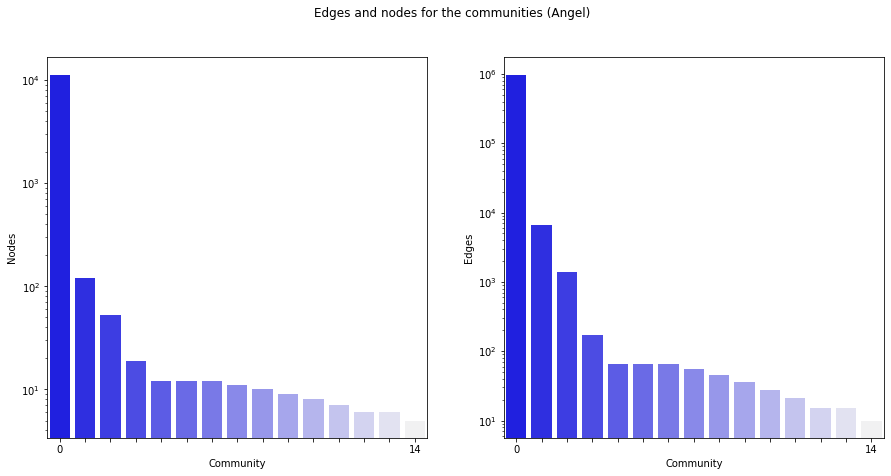

In [51]:
fig, axes = plt.subplots(1,2, figsize=(15, 7))

sns.barplot(ax=axes[0], 
            x=list(info_DA.keys()), 
            y=[c['nodes'] for c in info_DA.values()],
            palette='light:b_r')

axes[0].set_xlabel('Community')
axes[0].set_ylabel('Nodes')
axes[0].set_yscale('log')

# Show only min and max of x tick labels
min_max = [min(list(info_DA.keys())), max(list(info_DA.keys()))]
for index, label in enumerate(axes[0].get_xticklabels()):
   if index in min_max:
      label.set_visible(True)
   else:
      label.set_visible(False)


sns.barplot(ax=axes[1],
            x=list(info_DA.keys()),
            y=[c['edges'] for c in info_DA.values()],
            palette='light:b_r')

axes[1].set_xlabel('Community')
axes[1].set_ylabel('Edges')
axes[1].set_yscale('log')

# Show only min and max of x tick labels
for index, label in enumerate(axes[1].get_xticklabels()):
   if index in min_max:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.suptitle("Edges and nodes for the communities (Angel)")
plt.show()

In [52]:
fitness_functions(DA_coms)

INTERNAL EVALUATION

1 - Average Internal Degree: 
FitnessResult(min=4.0, max=173.29433628318583, score=29.455177974434612, std=47.076886607400084)


2 - Internal Edge Density: 
FitnessResult(min=0.015337139240922722, max=1.0, score=0.9301728027467805, std=0.24499800469154845)


3 - Conductance : 
FitnessResult(min=0.0007011635027556644, max=0.9831081081081081, score=0.6042637916456693, std=0.3076198198366482)


4 - Triangle Participation Ratio : 
FitnessResult(min=1.0, max=1.0, score=1.0, std=0.0)


5 - Newmann modularity : 
FitnessResult(min=None, max=None, score=0.01697446118424011, std=None)


6 - Expansion : 
FitnessResult(min=0.1215929203539823, max=232.8, score=44.18874454012504, std=58.75082214231575)


7 - Normalized cut : 
FitnessResult(min=0.07418539363355348, max=0.9836969903751632, score=0.6094075043584941, std=0.29842025723408755)


8 - Average ODF Degree : 
FitnessResult(min=0.1215929203539823, max=232.8, score=44.18874454012504, std=58.75082214231575)


9 - Flake ODF : 

In [53]:
w_genre_purity = compute_overall_purity(DA_coms.communities, genre)
genre_purity = compute_overall_purity(DA_coms.communities, genre, weighted=False)

In [54]:
w_publisher_purity = compute_overall_purity(DA_coms.communities, publisher)
publisher_purity = compute_overall_purity(DA_coms.communities, publisher, weighted=False)

In [55]:
print(f'GENRE')
print(f'Purity: {genre_purity}, Weighted: {w_genre_purity}')
print(f'Overall Network: {network_genre_purity}')

GENRE
Purity: 0.544643638511317, Weighted: 0.28429680759275233
Overall Network: 0.2714225053078556


In [56]:
print(f'PUBLISHER')
print(f'Purity: {publisher_purity}, Weighted: {w_publisher_purity}')
print(f'Overall Network: {network_publisher_purity}')

PUBLISHER
Purity: 0.36935591607575335, Weighted: 0.056600517687661764
Overall Network: 0.04704883227176221


## Approach 4: Entity Closeness
Communities as a set of nodes that can reach any member of the group crossing a very low number of edges

### Walk-trap

In [57]:
wt_coms = algorithms.walktrap(g)

In [58]:
wt_coms.method_name

'Walktrap'

In [59]:
info_wt = info_community(wt_coms.communities, wt_coms)
info_wt

{0: {'nodes': 1760, 'edges': 66659},
 1: {'nodes': 1463, 'edges': 139215},
 2: {'nodes': 1331, 'edges': 50701},
 3: {'nodes': 1264, 'edges': 73074},
 4: {'nodes': 312, 'edges': 48516},
 5: {'nodes': 287, 'edges': 39378},
 6: {'nodes': 244, 'edges': 29404},
 7: {'nodes': 236, 'edges': 20301},
 8: {'nodes': 211, 'edges': 22155},
 9: {'nodes': 184, 'edges': 16836},
 10: {'nodes': 179, 'edges': 15931},
 11: {'nodes': 169, 'edges': 13546},
 12: {'nodes': 157, 'edges': 12246},
 13: {'nodes': 138, 'edges': 9453},
 14: {'nodes': 116, 'edges': 6670},
 15: {'nodes': 113, 'edges': 6116},
 16: {'nodes': 113, 'edges': 6328},
 17: {'nodes': 98, 'edges': 3265},
 18: {'nodes': 90, 'edges': 4005},
 19: {'nodes': 90, 'edges': 4005},
 20: {'nodes': 89, 'edges': 3506},
 21: {'nodes': 89, 'edges': 3916},
 22: {'nodes': 80, 'edges': 3160},
 23: {'nodes': 79, 'edges': 3081},
 24: {'nodes': 77, 'edges': 2926},
 25: {'nodes': 75, 'edges': 2775},
 26: {'nodes': 71, 'edges': 2485},
 27: {'nodes': 69, 'edges': 23

In [60]:
print(f"Nodes: {evaluation.size(g, wt_coms)}")
print(f"Edges: {evaluation.edges_inside(g, wt_coms)}")
if wt_coms.overlap: 
    print('Overlapping')
else: print('No overlapping')

Nodes: FitnessResult(min=1, max=1760, score=63.240437158469945, std=216.0130716137466)
Edges: FitnessResult(min=0, max=139215, score=3525.9781420765025, std=14096.483585064861)
No overlapping


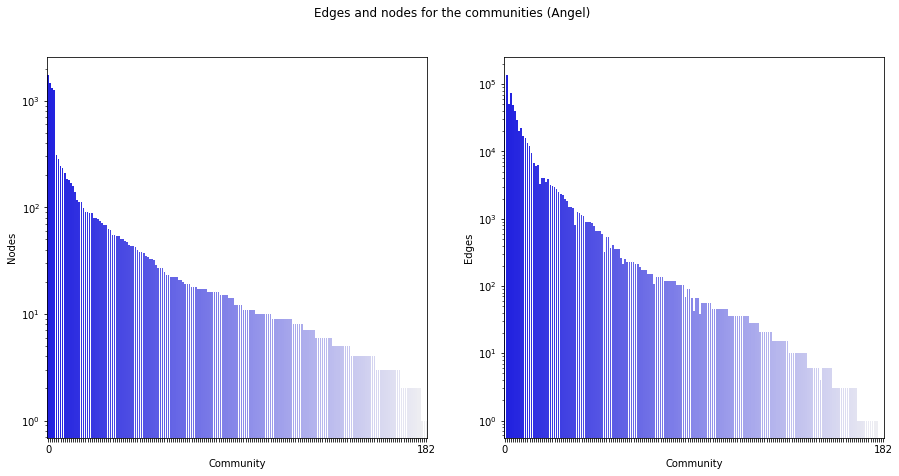

In [61]:
fig, axes = plt.subplots(1,2, figsize=(15, 7))

sns.barplot(ax=axes[0], 
            x=list(info_wt.keys()), 
            y=[c['nodes'] for c in info_wt.values()],
            palette='light:b_r')

axes[0].set_xlabel('Community')
axes[0].set_ylabel('Nodes')
axes[0].set_yscale('log')

# Show only min and max of x tick labels
min_max = [min(list(info_wt.keys())), max(list(info_wt.keys()))]
for index, label in enumerate(axes[0].get_xticklabels()):
   if index in min_max:
      label.set_visible(True)
   else:
      label.set_visible(False)


sns.barplot(ax=axes[1],
            x=list(info_wt.keys()),
            y=[c['edges'] for c in info_wt.values()],
            palette='light:b_r')

axes[1].set_xlabel('Community')
axes[1].set_ylabel('Edges')
axes[1].set_yscale('log')

# Show only min and max of x tick labels
for index, label in enumerate(axes[1].get_xticklabels()):
   if index in min_max:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.suptitle("Edges and nodes for the communities (Angel)")
plt.show()

In [62]:
fitness_functions(DA_coms)

INTERNAL EVALUATION

1 - Average Internal Degree: 
FitnessResult(min=4.0, max=173.29433628318583, score=29.455177974434612, std=47.076886607400084)


2 - Internal Edge Density: 
FitnessResult(min=0.015337139240922722, max=1.0, score=0.9301728027467805, std=0.24499800469154845)


3 - Conductance : 
FitnessResult(min=0.0007011635027556644, max=0.9831081081081081, score=0.6042637916456693, std=0.3076198198366482)


4 - Triangle Participation Ratio : 
FitnessResult(min=1.0, max=1.0, score=1.0, std=0.0)


5 - Newmann modularity : 
FitnessResult(min=None, max=None, score=0.01697446118424011, std=None)


6 - Expansion : 
FitnessResult(min=0.1215929203539823, max=232.8, score=44.18874454012504, std=58.75082214231575)


7 - Normalized cut : 
FitnessResult(min=0.07418539363355348, max=0.9836969903751632, score=0.6094075043584941, std=0.29842025723408755)


8 - Average ODF Degree : 
FitnessResult(min=0.1215929203539823, max=232.8, score=44.18874454012504, std=58.75082214231575)


9 - Flake ODF : 

In [63]:
w_genre_purity = compute_overall_purity(wt_coms.communities, genre)
genre_purity = compute_overall_purity(wt_coms.communities, genre, weighted=False)

In [64]:
w_publisher_purity = compute_overall_purity(wt_coms.communities, publisher)
publisher_purity = compute_overall_purity(wt_coms.communities, publisher, weighted=False)

In [65]:
print(f'GENRE')
print(f'Purity: {genre_purity}, Weighted: {w_genre_purity}')
print(f'Overall Network: {network_genre_purity}')

GENRE
Purity: 0.5749308153162792, Weighted: 0.5086840058757447
Overall Network: 0.2714225053078556


In [66]:
print(f'PUBLISHER')
print(f'Purity: {publisher_purity}, Weighted: {w_publisher_purity}')
print(f'Overall Network: {network_publisher_purity}')

PUBLISHER
Purity: 0.30689428786076256, Weighted: 0.1427460468331465
Overall Network: 0.04704883227176221


# External Evaluation: Partition Comparisons

## Partitions comparison scores
Compare different graph partition to assess their resemblance.

In [87]:
algs = [louv_coms, lp_coms, DA_coms, wt_coms]
#algs = [louv_coms, lp_coms] # test

In [88]:
combinations = list(itertools.combinations(algs, 2))

In [89]:
for combination in combinations:
    print(f"NF1 {combination[0].method_name} - {combination[1].method_name} = {evaluation.nf1(combination[0], combination[1])}")
    print()

NF1 Louvain - Label Propagation = MatchingResult(score=0.015583752476756592, std=None)

NF1 Louvain - ANGEL = MatchingResult(score=0.01289437585733882, std=None)

NF1 Louvain - Walktrap = MatchingResult(score=0.09587143103435351, std=None)

NF1 Label Propagation - ANGEL = MatchingResult(score=0.018790064102564105, std=None)

NF1 Label Propagation - Walktrap = MatchingResult(score=0.5695628415300545, std=None)

NF1 ANGEL - Walktrap = MatchingResult(score=0.0721311475409836, std=None)



In [90]:
for combination in combinations:
    print(f"ONMI {combination[0].method_name} - {combination[1].method_name} = {evaluation.overlapping_normalized_mutual_information_LFK(combination[0], combination[1])}")
    print()

ONMI Louvain - Label Propagation = MatchingResult(score=0.19389181780122366, std=None)

ONMI Louvain - ANGEL = MatchingResult(score=0.22731118189532018, std=None)

ONMI Louvain - Walktrap = MatchingResult(score=0.3033959860499724, std=None)

ONMI Label Propagation - ANGEL = MatchingResult(score=0.46858019761276526, std=None)

ONMI Label Propagation - Walktrap = MatchingResult(score=0.7696679591128319, std=None)

ONMI ANGEL - Walktrap = MatchingResult(score=0.4504629840002443, std=None)



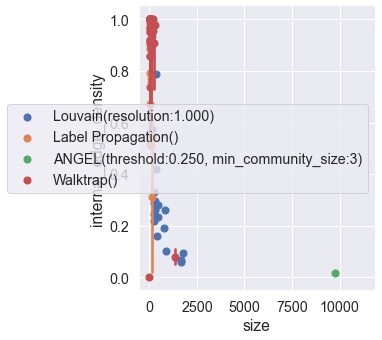

In [91]:
viz.plot_com_properties_relation(algs, evaluation.size, evaluation.internal_edge_density)

In [92]:
method_names = [alg.method_name for alg in algs]

In [93]:
f1_scores = list()
for alg1 in algs:
    f1_score = [evaluation.nf1(alg1, alg2).score for alg2 in algs]
    f1_scores.append(f1_score)

In [94]:
evaluation.nf1(DA_coms, DA_coms).score

0.8780000000000001

In [95]:
evaluation.overlapping_normalized_mutual_information_LFK(DA_coms, DA_coms).score

1

In [96]:
ONMI_scores = list()
for alg1 in algs:
    ONMI_score = [evaluation.overlapping_normalized_mutual_information_LFK(alg1, alg2).score for alg2 in algs]
    ONMI_scores.append(ONMI_score)

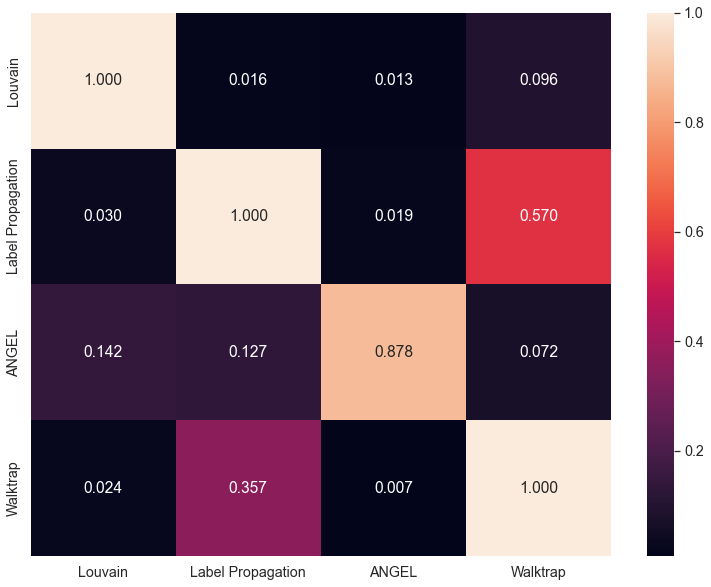

In [97]:
fig, ax = plt.subplots(figsize=(13,10))

sns.set(font_scale=1.3)
ax = sns.heatmap(f1_scores, annot=True, fmt='.3f', xticklabels=method_names, yticklabels=method_names)

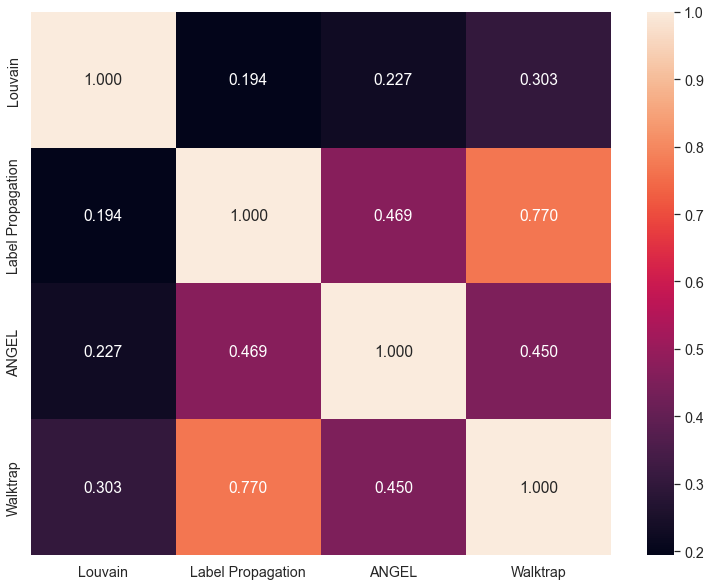

In [98]:
fig, ax = plt.subplots(figsize=(13,10))

sns.set(font_scale=1.3)
ax = sns.heatmap(ONMI_scores, annot=True, fmt='.3f', xticklabels=method_names, yticklabels=method_names)

## Community inspection

Walk-trap is the algorithm with the highest overall weighted purity based on genre (0.50)

In [134]:
communities = wt_coms.communities

In [135]:
rows = list()
attribute_names = ['book_genre', 'book_publisher', 'recommendations_received', 'year_of_publication']
for community_id, community in enumerate(communities, start=1):
    for node in community:
        row = [node, community_id]        
        for attribute_name in attribute_names:            
            row.append(info_nodes[node][attribute_name])
        rows.append(row)

# Create df
df = pd.DataFrame(columns=['node','community']+attribute_names, data=rows)

In [136]:
df.head()

,node,community,book_genre,book_publisher,recommendations_received,year_of_publication
0,0,1,Letterature straniere: testi,E/O,64.0,2019
1,1,1,Letterature straniere: testi,Sur,61.0,2020
2,3,1,Letteratura italiana: critica,Laterza,37.0,2020
3,4,1,Letteratura italiana: testi,Einaudi,36.0,2020
4,5,1,"Disegno, arti decorative e minori",Bao Publishing,35.0,2020


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11573 entries, 0 to 11572
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   node                      11573 non-null  int64  
 1   community                 11573 non-null  int64  
 2   book_genre                11573 non-null  object 
 3   book_publisher            11573 non-null  object 
 4   recommendations_received  11573 non-null  float64
 5   year_of_publication       11573 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 542.6+ KB


In [138]:
rows = list()
for community_id in sorted(df['community'].unique()):            
    community = df.groupby('community').get_group(community_id)
    # Compute stats for community    
    # Number of nodes
    n_nodes = len(community)
    # Genre stats
    mode_genre = str(community['book_genre'].mode()[0])    
    purity_genre = round(community['book_genre'].value_counts(normalize=True)[0],2)
    # Publisher stats
    mode_publisher = str(community['book_publisher'].mode()[0])
    purity_publisher = round(community['book_publisher'].value_counts(normalize=True)[0],2)
    # Year stats
    mean_year = round(community['year_of_publication'].mean())
    # Recommendations stats
    mean_reccoms = community['recommendations_received'].mean()
    # Create row
    rows.append([community_id, n_nodes, mode_genre, purity_genre, mode_publisher, purity_publisher, mean_year, mean_reccoms])
    
# Create df
communities_df = pd.DataFrame(columns=['community_id','nodes', 
                                       'genre_mode', 'genre_purity', 
                                       'publihser_mode', 'publisher_purity', 
                                       'avg_publication_year', 'avg_recommendations'], data=rows)

In [139]:
communities_df.set_index('community_id', inplace=True)
communities_df.head()

,nodes,genre_mode,genre_purity,publihser_mode,publisher_purity,avg_publication_year,avg_recommendations
community_id,,,,,,,
1,1760,Letterature straniere: testi,0.41,Einaudi,0.10,2018,2.480114
2,1463,Letterature straniere: testi,0.47,Minimum Fax,0.05,2019,2.274778
3,1331,Letteratura per ragazzi,0.89,Babalibri,0.07,2018,2.301277
4,1264,Letteratura italiana: testi,0.28,Einaudi,0.10,2019,2.487342
5,312,Letteratura per ragazzi,0.30,Einaudi,0.07,2017,2.663462


In [140]:
communities_df.corr()

,nodes,genre_purity,publisher_purity,avg_publication_year,avg_recommendations
nodes,1.000000,-0.076564,-0.224811,0.039404,0.525864
genre_purity,-0.076564,1.000000,0.291770,0.088987,0.120565
publisher_purity,-0.224811,0.291770,1.000000,-0.101871,-0.155347
avg_publication_year,0.039404,0.088987,-0.101871,1.000000,0.174769
avg_recommendations,0.525864,0.120565,-0.155347,0.174769,1.000000


In [141]:
communities_df['w_genre_purity'] = communities_df['nodes']/sum(communities_df['nodes']) * communities_df['genre_purity']

In [142]:
communities_df.sort_values(by='w_genre_purity', ascending=False).head(5)

,nodes,genre_mode,genre_purity,publihser_mode,publisher_purity,avg_publication_year,avg_recommendations,w_genre_purity
community_id,,,,,,,,
3,1331,Letteratura per ragazzi,0.89,Babalibri,0.07,2018,2.301277,0.102358
1,1760,Letterature straniere: testi,0.41,Einaudi,0.10,2018,2.480114,0.062352
2,1463,Letterature straniere: testi,0.47,Minimum Fax,0.05,2019,2.274778,0.059415
4,1264,Letteratura italiana: testi,0.28,Einaudi,0.10,2019,2.487342,0.030582
6,287,Letteratura per ragazzi,0.85,Mondadori,0.08,2021,2.547038,0.021079


In [143]:
node_list

,titolo,autore,editore,categoria,raccomandazioni-ricevute,anno-pubblicazione
id,,,,,,
0,Cambiare l'acqua ai fiori,Perrin Valérie,E/O,Letterature straniere: testi,64.0,2019
1,"Ragazza, donna, altro",Evaristo Bernardine,Sur,Letterature straniere: testi,61.0,2020
2,L'Ickabog,Rowling J. K.,Salani,Letteratura per ragazzi,44.0,2020
3,Dante,Barbero Alessandro,Laterza,Letteratura italiana: critica,37.0,2020
4,Borgo Sud,Di Pietrantonio Donatella,Einaudi,Letteratura italiana: testi,36.0,2020
...,...,...,...,...,...,...
20494,La notte delle ricostruzioni,Donaera Andrea,Tetra,Letteratura italiana: testi,1.0,2022
20495,L'ultimo raccolto,Zardi Paolo,Tetra,Letteratura italiana: testi,1.0,2022
20496,X. Una caccia,Aiolli Valerio,Tetra,Letteratura italiana: testi,1.0,2022


In [144]:
df = df.set_index('node').sort_index()
df

,community,book_genre,book_publisher,recommendations_received,year_of_publication
node,,,,,
0,1,Letterature straniere: testi,E/O,64.0,2019
1,1,Letterature straniere: testi,Sur,61.0,2020
2,4,Letteratura per ragazzi,Salani,44.0,2020
3,1,Letteratura italiana: critica,Laterza,37.0,2020
4,1,Letteratura italiana: testi,Einaudi,36.0,2020
...,...,...,...,...,...
20494,2,Letteratura italiana: testi,Tetra,1.0,2022
20495,2,Letteratura italiana: testi,Tetra,1.0,2022
20496,2,Letteratura italiana: testi,Tetra,1.0,2022


In [145]:
node_list1 = node_list.join(df['community'])

In [146]:
node_list1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11775 entries, 0 to 20498
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   titolo                    11775 non-null  object 
 1   autore                    11775 non-null  object 
 2   editore                   11775 non-null  object 
 3   categoria                 11775 non-null  object 
 4   raccomandazioni-ricevute  11775 non-null  float64
 5   anno-pubblicazione        11775 non-null  int64  
 6   community                 11573 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 994.0+ KB


In [147]:
# Missing values are nodes outside giant component
node_list1['community'].fillna(0, inplace=True)
node_list1

,titolo,autore,editore,categoria,raccomandazioni-ricevute,anno-pubblicazione,community
id,,,,,,,
0,Cambiare l'acqua ai fiori,Perrin Valérie,E/O,Letterature straniere: testi,64.0,2019,1.0
1,"Ragazza, donna, altro",Evaristo Bernardine,Sur,Letterature straniere: testi,61.0,2020,1.0
2,L'Ickabog,Rowling J. K.,Salani,Letteratura per ragazzi,44.0,2020,4.0
3,Dante,Barbero Alessandro,Laterza,Letteratura italiana: critica,37.0,2020,1.0
4,Borgo Sud,Di Pietrantonio Donatella,Einaudi,Letteratura italiana: testi,36.0,2020,1.0
...,...,...,...,...,...,...,...
20494,La notte delle ricostruzioni,Donaera Andrea,Tetra,Letteratura italiana: testi,1.0,2022,2.0
20495,L'ultimo raccolto,Zardi Paolo,Tetra,Letteratura italiana: testi,1.0,2022,2.0
20496,X. Una caccia,Aiolli Valerio,Tetra,Letteratura italiana: testi,1.0,2022,2.0


In [148]:
node_list1 = node_list1.astype({'community': 'int'})[['editore','categoria','community']]

In [149]:
node_list1.to_csv('data/node-list-w-communities.csv')